[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1ZDphxN3ejxgogC8mKsjEc2dKVdRV9HZw?usp=sharing)

# Anomaly Detection Using Autoencoder with Satellite Images and MNIST digits

## Autoencoder and anomaly detection

In an autoencoder model, an input data instance (a data vector, an image, a sound wave, etc) is compressed through encoding layers into a lower dimensional data representation, which is then decoded through decoding layers to reconstruct the input data instance. Thus, autoencoder is an unsupervised learning method that can generate low dimensional latent features of the data, allowing us to navigate a space of images or even more complicated data objects. Its architecture is simple but powerful enough to serve as key compartments of generative AI models like variational autoencoder, diffusion autoencoder, etc.

Anomaly in data broadly refers to any data points or patterns that are different from the majority of data points.

One application of autoencoder is the anomaly detection using reconstruction errors or latent features.




## Import libraries and define functions

In [ ]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
import tensorflow as tf
import time
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
# To plot training loss curves
!pip install -q plot_keras_history

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from plot_keras_history import show_history, plot_history

In [ ]:
print('TF Version:', tf.__version__)

TF Version: 2.12.0


In [ ]:
# Extract sample imgs and labels from a Dataset object
def extract_sample(Dataset, samid):
    img_batch = np.array([])
    label_arr = np.array([])

    for i in samid:
        img, label = next(iter(Dataset.skip(i).take(1)))
        if (len(img_batch) == 0):
            img_batch = img.numpy()
            label_arr = label.numpy()
        else:
            img_batch = np.concatenate((img_batch, img.numpy()), axis=0)
            label_arr = np.concatenate((label_arr, label.numpy()), axis=0)

    return img_batch, label_arr

## Satellite images of hurricane damage from Kaggle

The data are satellite images from Texas after Hurricane Harvey divided into two groups (damage and no_damage).

The data is downloaded from https://www.kaggle.com/datasets/kmader/satellite-images-of-hurricane-damage, and originally taken from [IEEE-dataport](https://ieee-dataport.org/open-access/detecting-damaged-buildings-post-hurricane-satellite-imagery-based-customized).

### Load Kaggle dataset directly to Google Colab

Following an [instruction](https://www.kaggle.com/discussions/general/74235) from Kaggle, the dataset was downloaded directly from Kaggle to Google Colab.

In [ ]:
!pip install -q kaggle

In [ ]:
# Before running this cell, download 'kaggle.json' (Kaggle API token) from your Kaggle profile
# and upload it to the Colab working directory.

# Make a directory named '.kaggle'
!mkdir -p ~/.kaggle
# Copy the 'kaggle.json' into a new directory.
!mv kaggle.json ~/.kaggle/
# Change the permission of the file.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# From the Kaggle dataset website, 'Copy API command' here to download the dataset (it is fast).
!kaggle datasets download -d kmader/satellite-images-of-hurricane-damage

 91% 57.0M/63.0M [00:01<00:00, 48.0MB/s]
100% 63.0M/63.0M [00:01<00:00, 49.1MB/s]


In [ ]:
# Unzip if necessary
!unzip -q satellite-images-of-hurricane-damage.zip -d satellite-images-of-hurricane-damage

### List of data files

In [ ]:
!ls -lha ./satellite-images-of-hurricane-damage/

total 24K
drwxr-xr-x 6 root root 4.0K Jun 23 01:53 .
drwxr-xr-x 1 root root 4.0K Jun 23 01:53 ..
drwxr-xr-x 4 root root 4.0K Jun 23 01:53 test
drwxr-xr-x 4 root root 4.0K Jun 23 01:53 test_another
drwxr-xr-x 4 root root 4.0K Jun 23 01:53 train_another
drwxr-xr-x 4 root root 4.0K Jun 23 01:53 validation_another


In [ ]:
# Data files
def print_dir_size(parent_path, dirname):
    print('{}:'.format(dirname))
    path = parent_path + dirname + '/'
    for subdir in os.listdir(path):
        fsizes = [os.path.getsize(path + subdir + '/' + x) for x in os.listdir(path + subdir)]
        print('|--' + subdir.ljust(20) + str(round(sum(fsizes)/1000000, 2)) + 'MB' + ' ({} files)'.format(len(fsizes)))
    print('')

parent_path = './satellite-images-of-hurricane-damage/'
print_dir_size(parent_path, 'train_another')
print_dir_size(parent_path, 'validation_another')
print_dir_size(parent_path, 'test_another')
print_dir_size(parent_path, 'test')

train_another:
|--no_damage           15.07MB (5000 files)
|--damage              12.56MB (5000 files)

validation_another:
|--no_damage           3.02MB (1000 files)
|--damage              2.52MB (1000 files)

test_another:
|--no_damage           3.01MB (1000 files)
|--damage              20.12MB (8000 files)

test:
|--no_damage           2.99MB (1000 files)
|--damage              2.53MB (1000 files)



### Create image Dataset objects

In [ ]:
# Use image_dataset_from_directory()
IMG_SIZE = (128, 128)
BATCH_SIZE = 1          # for easy data exploration

train_ds = tf.keras.utils.image_dataset_from_directory(
            directory='./satellite-images-of-hurricane-damage/train_another',
            labels='inferred',
            label_mode='int',
            class_names=['no_damage', 'damage'],          # damage = 1
            color_mode='rgb',
            batch_size=BATCH_SIZE,
            image_size=IMG_SIZE,
            shuffle=False,
            seed=618,
            validation_split=None,
            subset=None,
            interpolation='bilinear',
            follow_links=False,
            crop_to_aspect_ratio=False
)

Found 10000 files belonging to 2 classes.


In [ ]:
# Create validation and test dataset objects
val_ds = tf.keras.utils.image_dataset_from_directory(
            directory='./satellite-images-of-hurricane-damage/validation_another',
            labels='inferred',
            label_mode='int',
            class_names=['no_damage', 'damage'],          # damage = 1
            color_mode='rgb',
            batch_size=BATCH_SIZE,
            image_size=IMG_SIZE,
            shuffle=False,
            seed=618,
            validation_split=None,
            subset=None,
            interpolation='bilinear',
            follow_links=False,
            crop_to_aspect_ratio=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
            directory='./satellite-images-of-hurricane-damage/test',
            labels='inferred',
            label_mode='int',
            class_names=['no_damage', 'damage'],          # damage = 1
            color_mode='rgb',
            batch_size=BATCH_SIZE,
            image_size=IMG_SIZE,
            shuffle=False,
            seed=618,
            validation_split=None,
            subset=None,
            interpolation='bilinear',
            follow_links=False,
            crop_to_aspect_ratio=False
)

Found 2000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [ ]:
# Get all the labels
labels_dataset = train_ds.map(lambda x, y: y)

# Iterate over the labels dataset to get all the labels
train_labels = np.array([])
for label in labels_dataset:
    train_labels = np.concatenate((train_labels, np.array(label.numpy())))

print(train_labels[:40])
print(len(train_labels))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
10000


In [ ]:
# Check train labels
print(len(list(train_ds)))
print(train_labels[4995:5015])

10000
[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
# Sample example images in train data
tr_label1_samid = np.random.randint(0, 5000, size=8)
tr_label0_samid = np.random.randint(5000, 10000, size=8)
print(tr_label1_samid)
print(tr_label0_samid)

[3899  651 1239 1282 3377 2361  945 1080]
[8164 8944 5500 7307 9333 9081 8182 6735]


In [ ]:
# Sample example images with hurricane damage in train data
img_sample1, label_arr1 = extract_sample(train_ds, tr_label1_samid)

print(img_sample1.shape)
print(label_arr1)

(8, 128, 128, 3)
[1 1 1 1 1 1 1 1]


In [ ]:
# Sample example images with no damage in train data
img_sample0, label_arr0 = extract_sample(train_ds, tr_label0_samid)

print(img_sample0.shape)
print(label_arr0)

(8, 128, 128, 3)
[0 0 0 0 0 0 0 0]


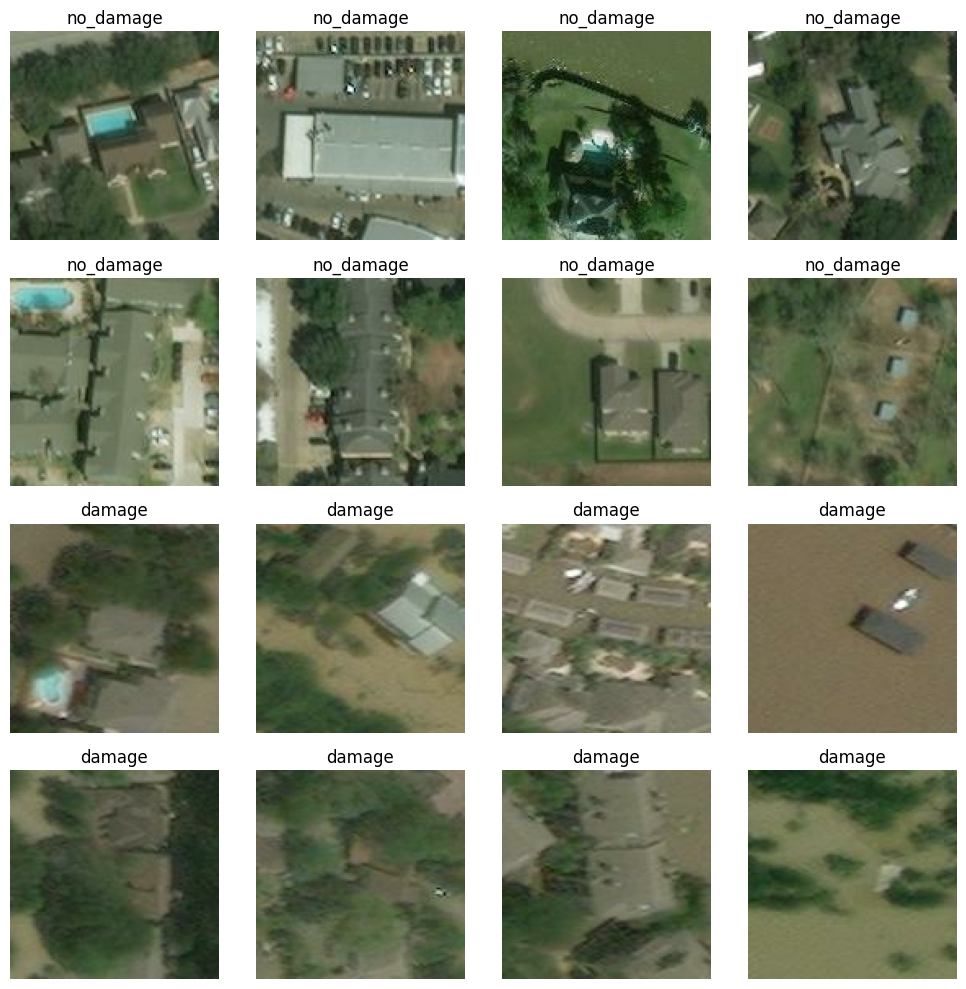

In [ ]:
# Visualize data examples
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for i in range(8):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(img_sample0[i].astype("uint8"))
    label = label_arr0[i]
    plt.title(class_names[label])
    plt.axis('off')
    ax = plt.subplot(4, 4, i + 1 + 8)
    plt.imshow(img_sample1[i].astype("uint8"))
    label = label_arr1[i]
    plt.title(class_names[label])
    plt.axis('off')
plt.tight_layout()

In [ ]:
# Rescale train/val/test datasets and prepare for the reconstruction modeling
rescalingLayer = layers.Rescaling(1./255)
train_ds2 = train_ds.map(lambda x, y: (rescalingLayer(x), y))
train_ds2 = train_ds2.map(lambda x, y: (x, x))
train_ds2 = train_ds2.prefetch(tf.data.AUTOTUNE)

print(train_ds2.element_spec)

val_ds2 = val_ds.map(lambda x, y: (rescalingLayer(x), y))
val_ds2 = val_ds2.map(lambda x, y: (x, x))
val_ds2 = val_ds2.prefetch(tf.data.AUTOTUNE)

test_ds2 = test_ds.map(lambda x, y: (rescalingLayer(x), y))
test_ds2 = test_ds2.map(lambda x, y: (x, x))
test_ds2 = test_ds2.prefetch(tf.data.AUTOTUNE)

(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None))


In [ ]:
# Check scaled data
image_batch, tmp = next(iter(train_ds2))
print(image_batch.shape)
tmp = image_batch[0].numpy().flatten()
pd.DataFrame(tmp).describe().transpose()

(1, 128, 128, 3)


count      mean       std       min       25%       50%       75%  max
0  49152.0  0.261661  0.117525  0.078431  0.192157  0.243137  0.298039  1.0

### Define convolutional autoencoder and its encoder/decoder

In [ ]:
def convAutoencoder(IMG_SHAPE, num_filters_1st, num_filters_2nd, num_filters_3rd):
    # Define conv autoencoder, encoder, decoder models with 3 poolings/upsampling layers.
    # You can build the models with varying numbers of convolution filters in encoding/decoding layers,
    # as well as different image sizes.

    input_img = tf.keras.Input(shape=IMG_SHAPE)
    x = layers.Conv2D(num_filters_1st, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D( (2, 2), padding='same' )(x)
    x = layers.Conv2D(num_filters_2nd, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D( (2, 2), padding='same' )(x)
    x = layers.Conv2D(num_filters_3rd, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D( (2, 2), padding='same' )(x)

    x = layers.Conv2D(num_filters_3rd, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(num_filters_2nd, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(num_filters_1st, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2,2))(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    # Create autoencoder
    autoencoder = Model(input_img, decoded)
    # Create encoder, decoder
    encoder = Model(input_img, encoded)
    decoder = Model(encoded, decoded)

    encoding_shape = encoded.shape[1:]
    print("Encoding shape: {}".format(encoding_shape))
    decoding_shape = decoded.shape[1:]
    print("Decoding shape: {}".format(decoding_shape))

    return autoencoder, encoder, decoder

In [ ]:
# Define models
IMG_SHAPE = (128, 128, 3)
num_filters_1st = 16
num_filters_2nd = 32
num_filters_3rd = 64

convAutoencoder1, encoder1, decoder1 = convAutoencoder(IMG_SHAPE, num_filters_1st, num_filters_2nd, num_filters_3rd)

Encoding shape: (16, 16, 64)
Decoding shape: (128, 128, 3)


In [ ]:
convAutoencoder1.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_53 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_54 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_55 (Conv2D)          (None, 32, 32, 64)        184

### Train the model

In [ ]:
T0 = time.time()
convAutoencoder1.compile(optimizer='adam',
                         loss=tf.keras.losses.MeanSquaredError(),
                         metrics=['binary_crossentropy'])
# Metric = binary_crossentropy was calculated together as a reference,
# because the crossentropy also worked as the loss function in preliminary learning trials.
# It was even faster and minimized at ~0.59.
# In principle, MSE loss is appropriate here, but binary_crossentropy will be also working.

history1 = convAutoencoder1.fit(train_ds2,
                                validation_data=val_ds2,
                                shuffle=True,
                                epochs=20,
                                batch_size=64,
                                verbose=2)
T1 = time.time()
print(T1-T0, 'sec')

Epoch 1/20
10000/10000 - 60s - loss: 0.0024 - binary_crossentropy: 0.6030 - val_loss: 0.0015 - val_binary_crossentropy: 0.6004 - 60s/epoch - 6ms/step
Epoch 2/20
10000/10000 - 56s - loss: 0.0014 - binary_crossentropy: 0.6000 - val_loss: 0.0013 - val_binary_crossentropy: 0.6000 - 56s/epoch - 6ms/step
Epoch 3/20
10000/10000 - 56s - loss: 0.0012 - binary_crossentropy: 0.5997 - val_loss: 0.0012 - val_binary_crossentropy: 0.5996 - 56s/epoch - 6ms/step
Epoch 4/20
10000/10000 - 57s - loss: 0.0012 - binary_crossentropy: 0.5996 - val_loss: 0.0010 - val_binary_crossentropy: 0.5992 - 57s/epoch - 6ms/step
Epoch 5/20
10000/10000 - 57s - loss: 0.0011 - binary_crossentropy: 0.5993 - val_loss: 0.0010 - val_binary_crossentropy: 0.5992 - 57s/epoch - 6ms/step
Epoch 6/20
10000/10000 - 61s - loss: 0.0010 - binary_crossentropy: 0.5992 - val_loss: 9.8892e-04 - val_binary_crossentropy: 0.5992 - 61s/epoch - 6ms/step
Epoch 7/20
10000/10000 - 56s - loss: 9.9212e-04 - binary_crossentropy: 0.5991 - val_loss: 9.5076

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <Axes: title={'center': 'Binary crossentropy'}, xlabel='Epochs', ylabel='Binary crossentropy'>],
       dtype=object))

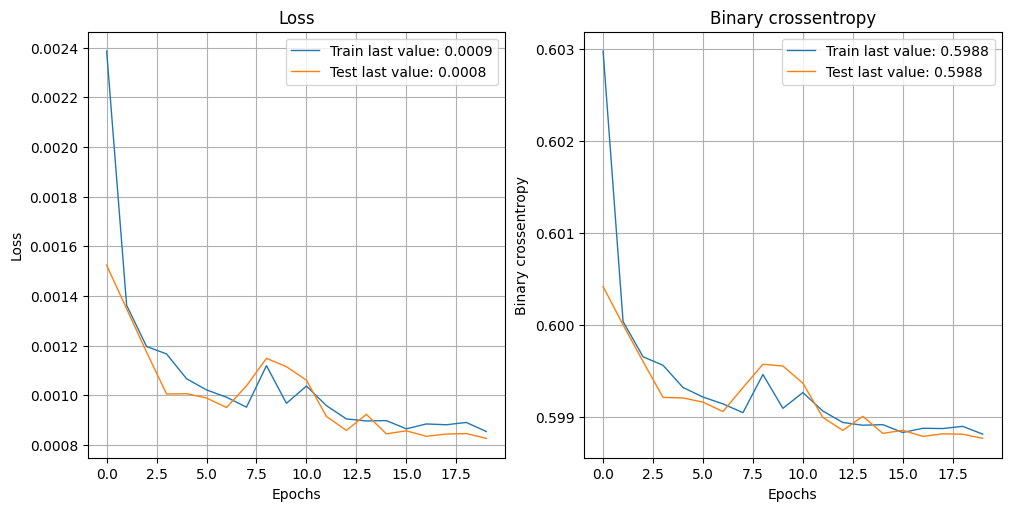

In [ ]:
plot_history(history1)

### Visualize original/reconstructed images in train data

1/1 [==============================] - 0s 20ms/step


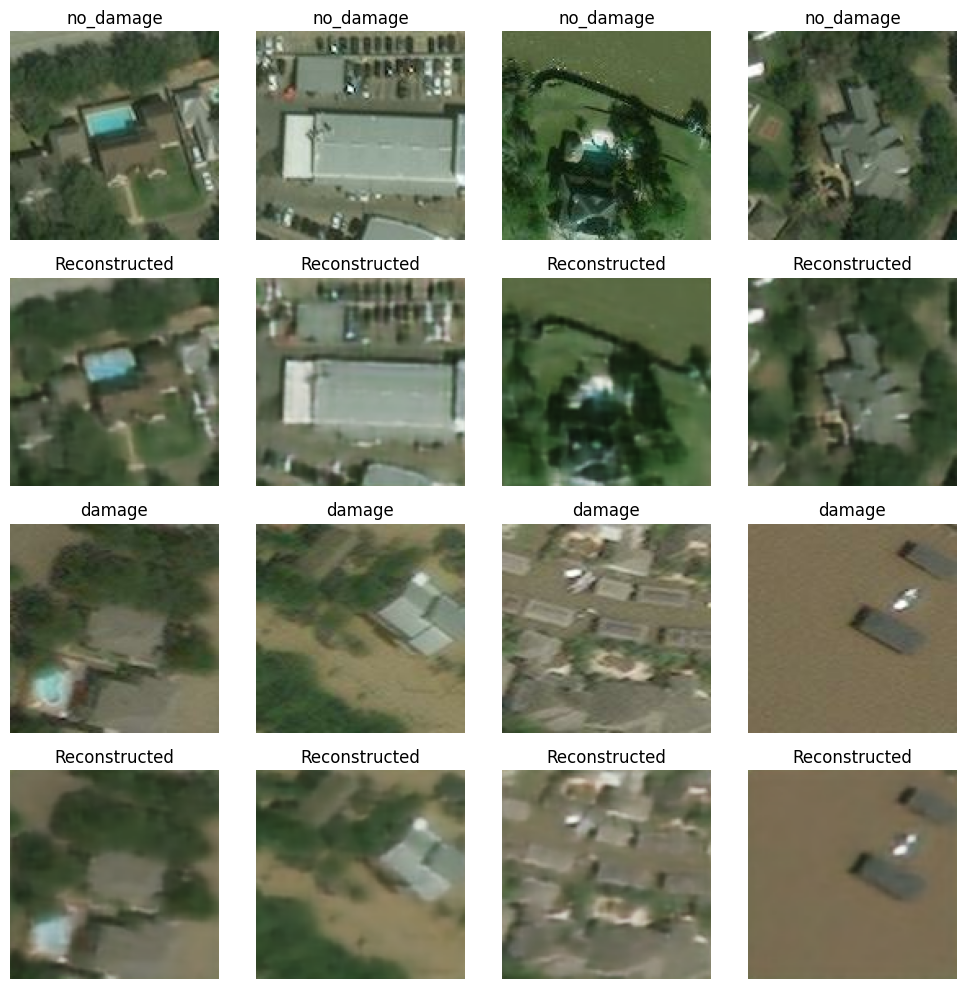

In [ ]:
class_names = train_ds.class_names

# label=0
recon_sample0 = convAutoencoder1.predict(img_sample0 / 255)
recon_sample0 = recon_sample0 * 255

plt.figure(figsize=(10, 10))

for i in range(4):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(img_sample0[i].astype("uint8"))
    label = label_arr0[i]
    plt.title(class_names[label])
    plt.axis('off')
    ax = plt.subplot(4, 4, i + 1 + 4)
    plt.imshow(recon_sample0[i].astype("uint8"))
    plt.title('Reconstructed')
    plt.axis('off')

# label=1
recon_sample1 = convAutoencoder1.predict(img_sample1 / 255)
recon_sample1 = recon_sample1 * 255

for i in range(4):
    ax = plt.subplot(4, 4, i + 1 + 8)
    plt.imshow(img_sample1[i].astype("uint8"))
    label = label_arr1[i]
    plt.title(class_names[label])
    plt.axis('off')
    ax = plt.subplot(4, 4, i + 1 + 12)
    plt.imshow(recon_sample1[i].astype("uint8"))
    plt.title('Reconstructed')
    plt.axis('off')

plt.tight_layout()

In [ ]:
# Save the models for future use
#convAutoencoder1.save('convAutoencoder1-0622.keras')
#encoder1.save('encoder1-0622.keras')
#decoder1.save('decoder1-0622.keras')

# Load the model
#convAutoencoder1 = tf.keras.models.load_model('convAutoencoder1.keras')

In [ ]:
encoder1 = tf.keras.models.load_model('encoder1-0622.keras')  # to be deleted

### Mean absolute errors (MAEs) in train data

In [ ]:
# Reconstruct the entire train images
pred_tr = convAutoencoder1.predict(train_ds2)

10000/10000 [==============================] - 26s 3ms/step


In [ ]:
# Compute MAEs using tf.keras.losses.mae()
maes_tr = []

k = 0
for im_batch, tmp in train_ds2:
  im_batch2 = im_batch.numpy().reshape((len(im_batch.numpy()), np.prod(im_batch.numpy().shape[1:])))
  batch_pred2 = pred_tr[k].reshape(1, np.prod(pred_tr.shape[1:]))
  mae_batch = tf.keras.losses.mae(im_batch2, batch_pred2)
  maes_tr.extend(mae_batch.numpy())
  k = k + 1

In [ ]:
# Summary of MAEs in train
maes_df = pd.DataFrame(maes_tr)
maes_df.describe().transpose()

count      mean       std       min       25%       50%       75%  \
0  10000.0  0.018949  0.006001  0.005512  0.014094  0.018368  0.022432   

        max  
0  0.072462

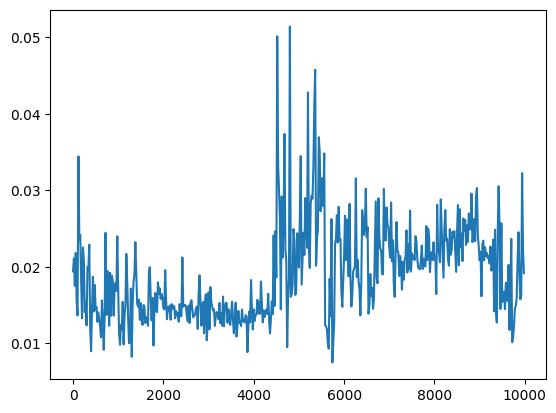

In [ ]:
# Check loosely MAEs along ID
ids = range(0, 9999, 20)
maes_tr_arr = np.array(maes_tr)
subMaes = maes_tr_arr[ids]
plt.plot(ids, subMaes)

- Since train_labels are 1 in range(0, 5000) and 0 in range(5000,10000), the plot roughly shows that the reconstruction errors for no_damage images tend to be higher than damage images. But, there are the images with very high reconstruction errors at the end of the file list of damage images and at the beginning of no_damage images.

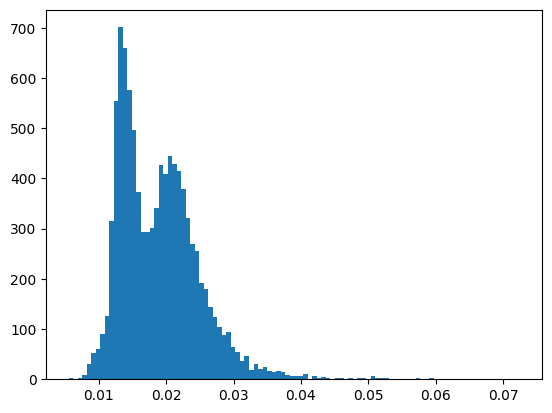

In [ ]:
# Reconstruction error histogram
plt.hist(maes_tr, bins=100)
plt.show()

- The reconstruction errors in train data show bi-modality.

In [ ]:
# Reconstruction errors per label
maes_tr_arr1 = maes_tr_arr[train_labels == 1]
print(maes_tr_arr1.shape)
maes_tr_arr0 = maes_tr_arr[train_labels == 0]
print(maes_tr_arr0.shape)

(5000,)
(5000,)


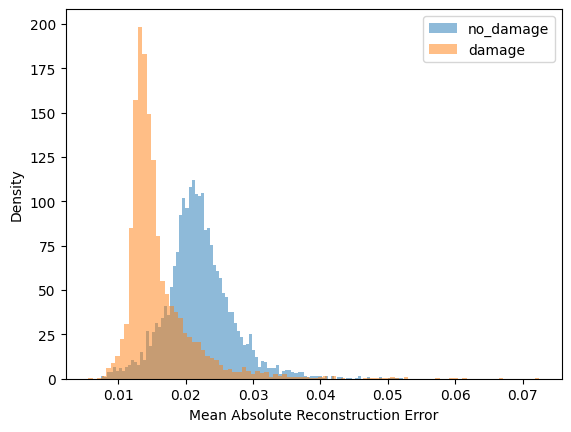

In [ ]:
# Reconstruction error distribution per label
plt.hist(maes_tr_arr0, bins=100, alpha=0.5, label='no_damage', density=True)
plt.hist(maes_tr_arr1, bins=100, alpha=0.5, label='damage', density=True)
plt.legend()
plt.xlabel('Mean Absolute Reconstruction Error')
plt.ylabel('Density')
plt.show()

1. Whether damaged or not is correlated with the reconstruction error.

2. Interestingly, images of damage have smaller reconstruction errors in average, but the images with extremely large reconstruction errors also belong to the damage class.

### Anomaly detection in train data

In [ ]:
# 20 smallest/largest errors
ord = np.argsort(maes_tr_arr)
print(ord.shape)
print(ord[:5])

smallestLosses = maes_tr_arr[ord[:20]]
largestLosses = maes_tr_arr[ord[-20:]]

smallestLosses_label = train_labels[ord[:20]]
largestLosses_label = train_labels[ord[-20:]]

print(smallestLosses)
print(largestLosses)
print(smallestLosses_label)
print(largestLosses_label)

(10000,)
[ 897 1328  799 5725 5740]
[0.00551159 0.00596518 0.00702786 0.00736839 0.00746083 0.00754944
 0.00759779 0.00773588 0.00785901 0.00798094 0.00799759 0.00804725
 0.00812926 0.00820733 0.00833042 0.00834675 0.00838459 0.0083975
 0.00844131 0.00844461]
[0.05049079 0.05050137 0.05050822 0.05055982 0.05140929 0.05144208
 0.05164243 0.05186374 0.05232575 0.05272341 0.0527498  0.05285925
 0.05744109 0.05753921 0.05918469 0.05973153 0.05991529 0.06134537
 0.06658722 0.07246239]
[1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1.]
[0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
# Cases with the largest reconst errors
ids_largestError = ord[-8:]

img_sample_errLarge, label_arr_errLarge = extract_sample(train_ds, ids_largestError)

print(img_sample_errLarge.shape)
print(label_arr_errLarge)

(8, 128, 128, 3)
[1 1 1 1 1 1 1 1]


1/1 [==============================] - 0s 22ms/step


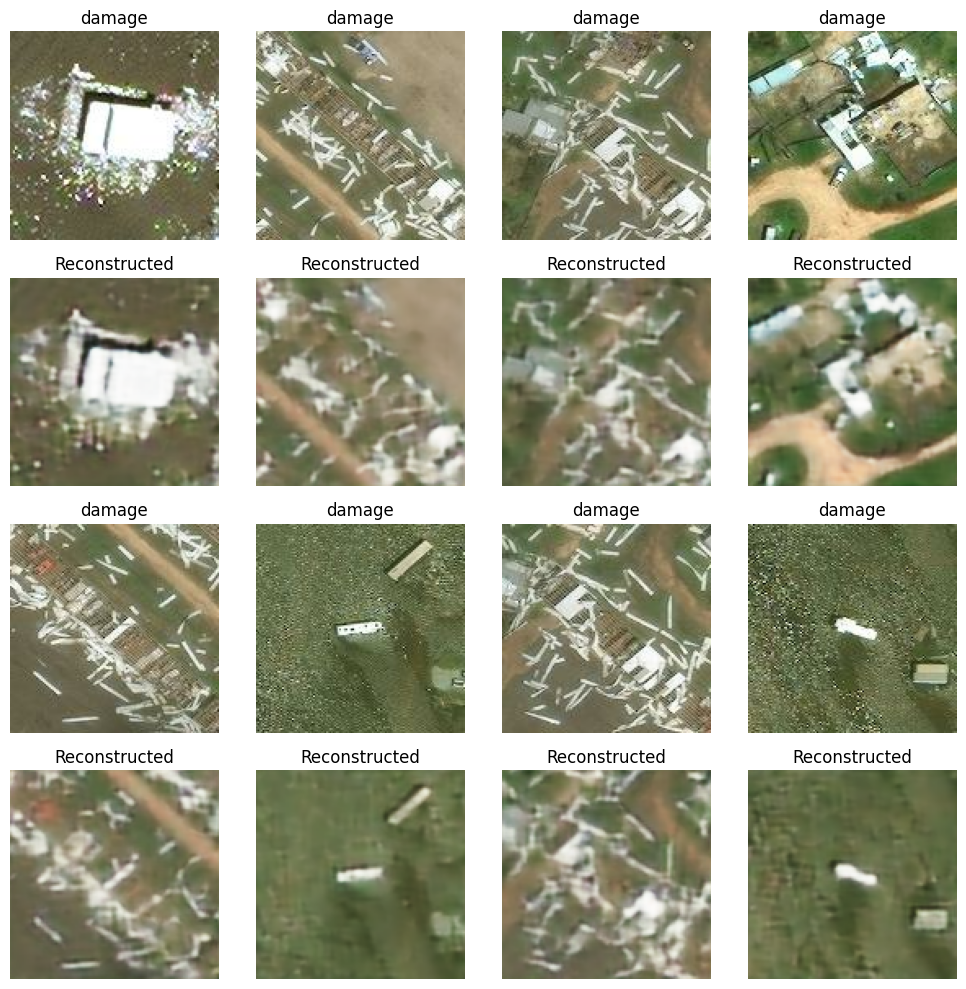

In [ ]:
# Visualize images with the largest reconstruction errors
class_names = train_ds.class_names

# Reconstructed images
recon_sample_errLarge = convAutoencoder1.predict(img_sample_errLarge / 255)
recon_sample_errLarge = recon_sample_errLarge * 255

plt.figure(figsize=(10, 10))

for i in range(4):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(img_sample_errLarge[i].astype("uint8"))
    label = label_arr_errLarge[i]
    plt.title(class_names[label])
    plt.axis('off')
    ax = plt.subplot(4, 4, i + 1 + 4)
    plt.imshow(recon_sample_errLarge[i].astype("uint8"))
    plt.title('Reconstructed')
    plt.axis('off')

for i in range(4, 8):
    ax = plt.subplot(4, 4, i + 1 + 4)
    plt.imshow(img_sample_errLarge[i].astype("uint8"))
    label = label_arr_errLarge[i]
    plt.title(class_names[label])
    plt.axis('off')
    ax = plt.subplot(4, 4, i + 1 + 8)
    plt.imshow(recon_sample_errLarge[i].astype("uint8"))
    plt.title('Reconstructed')
    plt.axis('off')
plt.tight_layout()

- Using the autoencoder model, we could locate the satellite images showing the most severe hurricane damage. These had the highest reconstruction errors and displayed lots of debris and completely destroyed buildings.

In [ ]:
# Cases with the smallest reconst errors
ids_smallestError = ord[:8]

img_sample_errSmall, label_arr_errSmall = extract_sample(train_ds, ids_smallestError)

print(img_sample_errSmall.shape)
print(label_arr_errSmall)

(8, 128, 128, 3)
[1 1 1 0 0 0 1 1]


1/1 [==============================] - 0s 24ms/step


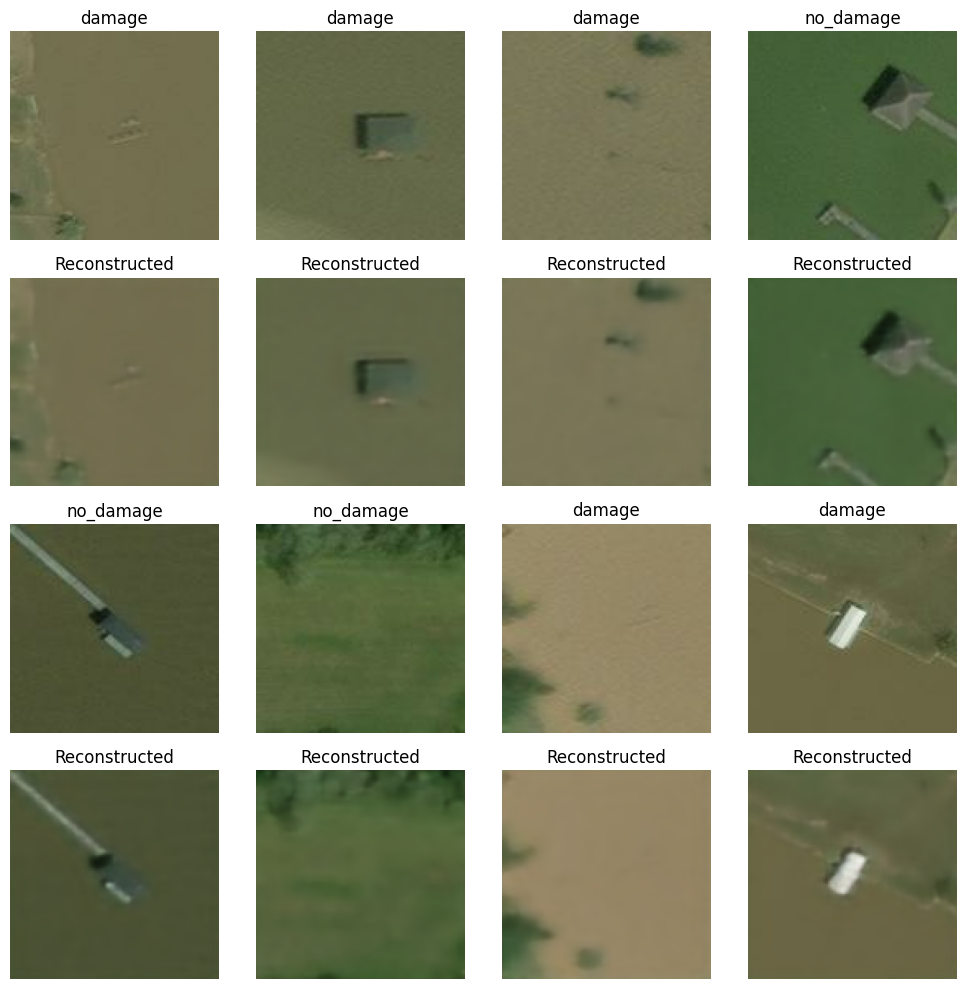

In [ ]:
# Visualize images with the smallest reconstruction errors
class_names = train_ds.class_names

# Reconstructed images
recon_sample_errSmall = convAutoencoder1.predict(img_sample_errSmall / 255)
recon_sample_errSmall = recon_sample_errSmall * 255

plt.figure(figsize=(10, 10))

for i in range(4):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(img_sample_errSmall[i].astype("uint8"))
    label = label_arr_errSmall[i]
    plt.title(class_names[label])
    plt.axis('off')
    ax = plt.subplot(4, 4, i + 1 + 4)
    plt.imshow(recon_sample_errSmall[i].astype("uint8"))
    plt.title('Reconstructed')
    plt.axis('off')

for i in range(4, 8):
    ax = plt.subplot(4, 4, i + 1 + 4)
    plt.imshow(img_sample_errSmall[i].astype("uint8"))
    label = label_arr_errSmall[i]
    plt.title(class_names[label])
    plt.axis('off')
    ax = plt.subplot(4, 4, i + 1 + 8)
    plt.imshow(recon_sample_errSmall[i].astype("uint8"))
    plt.title('Reconstructed')
    plt.axis('off')
plt.tight_layout()


- On the other hand, the images with the smallest reconstruction errors had mixed labels. They show monotonic backgrounds in common, which were flood in the damage class or grass in the no_damage class.

### Anomaly detection in test data

In [ ]:
# Reconstruct the entire test images
pred_test = convAutoencoder1.predict(test_ds2)

2000/2000 [==============================] - 5s 3ms/step


In [ ]:
# Compute MAE
maes_test = []

k = 0
for im_batch, tmp in test_ds2:
  im_batch2 = im_batch.numpy().reshape((len(im_batch.numpy()), np.prod(im_batch.numpy().shape[1:])))
  batch_pred2 = pred_test[k].reshape(1, np.prod(pred_test.shape[1:]))
  mae_batch_test = tf.keras.losses.mae(im_batch2, batch_pred2)
  maes_test.extend(mae_batch_test.numpy())
  k = k + 1

In [ ]:
# Summary of test MAEs
mae_df_test = pd.DataFrame(maes_test)
mae_df_test.describe().transpose()

count      mean      std       min       25%      50%       75%      max
0  2000.0  0.018879  0.00584  0.005965  0.014188  0.01825  0.022409  0.06825

In [ ]:
# Get labels of test data
labels_dataset = test_ds.map(lambda x, y: y)

# Iterate over the labels dataset to get all the labels
test_labels = np.array([])
for label in labels_dataset:
    test_labels = np.concatenate((test_labels, np.array(label.numpy())))

print(test_labels[:40])
print(len(test_labels))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
2000


In [ ]:
# Test labels are 1 in range(0, 1000) and 0 in range(1000, 2000)
test_labels[995:1010]

array([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

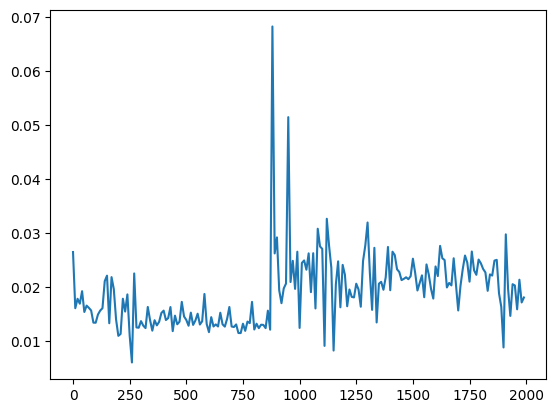

In [ ]:
# Check loosely the MAEs along test ID
ids = range(0, 1999, 10)
maes_test_arr = np.array(maes_test)
subMaes = maes_test_arr[ids]
plt.plot(ids, subMaes)

In [ ]:
# Test MAEs per label
maes_test_arr1 = maes_test_arr[test_labels == 1]
print(maes_test_arr1.shape)
maes_test_arr0 = maes_test_arr[test_labels == 0]
print(maes_test_arr0.shape)

(1000,)
(1000,)


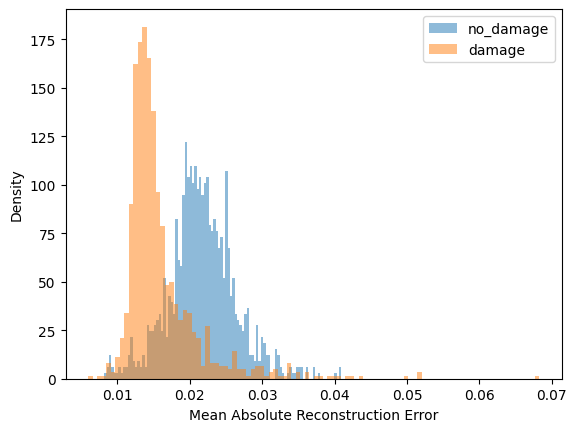

In [ ]:
# Test MAE distribution per label
plt.hist(maes_test_arr0, bins=100, alpha=0.5, label='no_damage', density=True)
plt.hist(maes_test_arr1, bins=100, alpha=0.5, label='damage', density=True)
plt.legend()
plt.xlabel('Mean Absolute Reconstruction Error')
plt.ylabel('Density')
plt.show()

- The pattern is the same as in train data.

In [ ]:
# 20 smallest/largest losses
ord = np.argsort(maes_test_arr)
print(ord.shape)
print(ord[:5])

smallestLosses = maes_test_arr[ord[:20]]
largestLosses = maes_test_arr[ord[-20:]]

smallestLosses_label = test_labels[ord[:20]]
largestLosses_label = test_labels[ord[-20:]]

print(smallestLosses)
print(largestLosses)
print(smallestLosses_label)
print(largestLosses_label)

(2000,)
[ 260  189 1150  257 1151]
[0.00596518 0.00739051 0.00817415 0.00841861 0.00854291 0.00856054
 0.00874947 0.00883533 0.00886363 0.00891938 0.00892833 0.00896055
 0.00897216 0.00903837 0.00905348 0.0093529  0.00941316 0.00942064
 0.0094937  0.00960248]
[0.03617785 0.03634601 0.03716791 0.03720437 0.03732876 0.03784612
 0.03808801 0.0392879  0.04017402 0.04019435 0.0405577  0.04082722
 0.04094328 0.04205417 0.04216829 0.04394936 0.05016314 0.05144208
 0.05150774 0.06824978]
[1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0.]
[0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
# Cases with the largest reconst errors
ids_largestError = ord[-8:]

img_sample_errLarge_test, label_arr_errLarge_test = extract_sample(test_ds, ids_largestError)

print(img_sample_errLarge_test.shape)
print(label_arr_errLarge_test)

(8, 128, 128, 3)
[0 1 1 1 1 1 1 1]


1/1 [==============================] - 0s 22ms/step


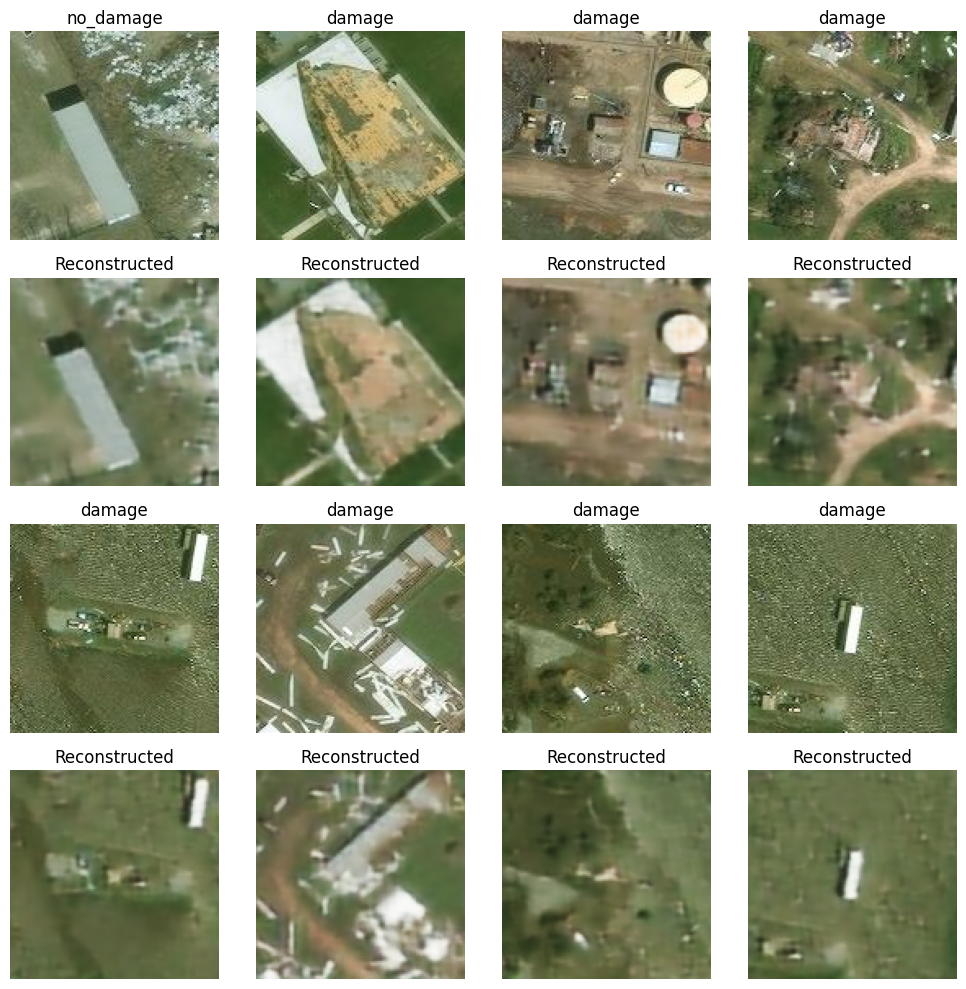

In [ ]:
# Visualize images with the largest reconstruction errors
class_names = test_ds.class_names

# Reconstructed images
recon_sample_errLarge_test = convAutoencoder1.predict(img_sample_errLarge_test / 255)
recon_sample_errLarge_test = recon_sample_errLarge_test * 255

plt.figure(figsize=(10, 10))

for i in range(4):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(img_sample_errLarge_test[i].astype("uint8"))
    label = label_arr_errLarge_test[i]
    plt.title(class_names[label])
    plt.axis('off')
    ax = plt.subplot(4, 4, i + 1 + 4)
    plt.imshow(recon_sample_errLarge_test[i].astype("uint8"))
    plt.title('Reconstructed')
    plt.axis('off')

for i in range(4, 8):
    ax = plt.subplot(4, 4, i + 1 + 4)
    plt.imshow(img_sample_errLarge_test[i].astype("uint8"))
    label = label_arr_errLarge_test[i]
    plt.title(class_names[label])
    plt.axis('off')
    ax = plt.subplot(4, 4, i + 1 + 8)
    plt.imshow(recon_sample_errLarge_test[i].astype("uint8"))
    plt.title('Reconstructed')
    plt.axis('off')

plt.tight_layout()

- In test data, abnormal images showing severe hurricane damage were found based on the largest reconstruction error.
- There was one exceptional image from the no_damage class. It contained lots of small objects in the background which looked like debris. In classification, this data point would be hard to classify correctly.

### Encoded latent features in test data

> Now let's look at the low dimensional representation by the autoencoder.

In [ ]:
# Get the encoded images using the predefined encoder model in test data
encoded_imgs = encoder1.predict(test_ds2)
print(encoded_imgs.shape)

2000/2000 [==============================] - 20s 10ms/step
(2000, 16, 16, 64)


In [ ]:
# Encoded images are flattened and fed into simple principal component analysis for fast 2-dim visualization
encoded_datmat = encoded_imgs.reshape((len(encoded_imgs), np.prod(encoded_imgs.shape[1:])))
print(encoded_datmat.shape)
pca = PCA(n_components=2)
pc_mat = pca.fit_transform(encoded_datmat)

(2000, 16384)


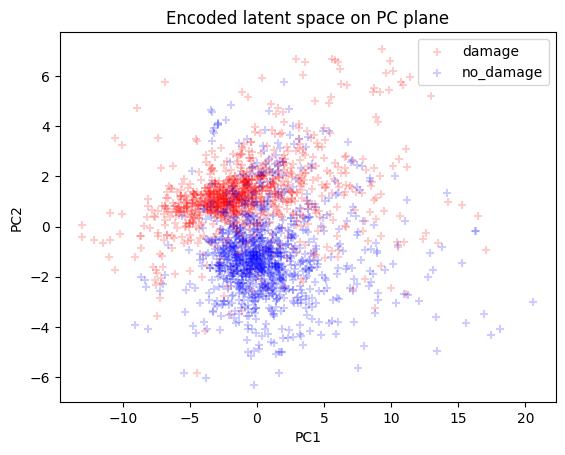

In [ ]:
# Visualize encoded latent space for test data
indic = (test_labels == 1)
notindic = [not x for x in indic]
plt.scatter(pc_mat[indic, 0], pc_mat[indic, 1], c='red',
            alpha=0.2, marker='+', label='damage')
plt.scatter(pc_mat[notindic, 0], pc_mat[notindic, 1], c='blue',
            alpha=0.2, marker='+', label='no_damage')

plt.legend(loc='best')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Encoded latent space on PC plane')
plt.show()

1. Surprisingly, the encoded images showed good separation between damage and no_damage classes, even though the autoencoder model had no information on the labels.
2. Below, it is shown that the same PC analysis with raw images do not show such good separation.
3. Thus, the encoding layers, which are three chains of convolution and max-pooling, transformed the raw pixel variables into meaningful features which can tell the differences between the images of damaged scene and the images of intact scene.
4. This shows why a convolutional neural network will be working well for the classification with this dataset.

#### How about raw image pixel features?

In [ ]:
# Get the entire test images
img_batch_test = np.array([])
label_arr_test = np.array([])

for img, label in tqdm(test_ds.take(-1), desc='Extracting test images'):
    if (len(img_batch_test) == 0):
        img_batch_test = img.numpy()
        label_arr_test = label.numpy()
    else:
        img_batch_test = np.concatenate((img_batch_test, img.numpy()), axis=0)
        label_arr_test = np.concatenate((label_arr_test, label.numpy()), axis=0)

Extracting test images: 100%|██████████| 2000/2000 [03:21<00:00,  9.90it/s]


In [ ]:
img_batch_test.shape

(2000, 128, 128, 3)

In [ ]:
# Raw test images are flattened and fed into simple principal component analysis for fast 2-dim visualization
testImg_datmat = img_batch_test.reshape((len(img_batch_test), np.prod(img_batch_test.shape[1:])))
print(testImg_datmat.shape)
pca = PCA(n_components=2)
pc_mat_rawTestImg = pca.fit_transform(testImg_datmat)

(2000, 49152)


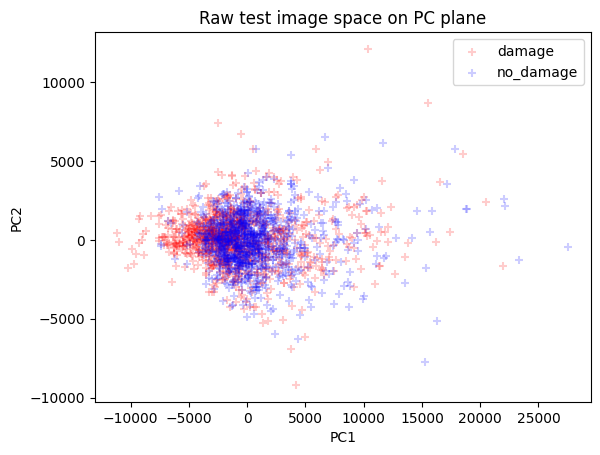

In [ ]:
# Visualize the space of raw test images
indic = (test_labels == 1)
notindic = [not x for x in indic]
plt.scatter(pc_mat_rawTestImg[indic, 0], pc_mat_rawTestImg[indic, 1], c='red',
            alpha=0.2, marker='+', label='damage')
plt.scatter(pc_mat_rawTestImg[notindic, 0], pc_mat_rawTestImg[notindic, 1], c='blue',
            alpha=0.2, marker='+', label='no_damage')

plt.legend(loc='best')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Raw test image space on PC plane')
plt.show()

- Raw image pixels do not show good separation between the two classes, though a portion of damage images show mild separation (when PC1 is around -5,000).

## MNIST hand-written digits

In [ ]:
from tensorflow.keras.datasets import mnist

### Load MNIST digits data

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train/255.0
x_test = x_test/255.0
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


### Define the autoencoder

In [ ]:
# Define the autoencoder with 3 layers of maxpooling/upsampling
input_img = tf.keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D( (2, 2), padding='same' )(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D( (2, 2), padding='same' )(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2,2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

encoding_shape = encoded.shape[1:]
print("Encoding shape: {}".format(encoding_shape))
decoding_shape = decoded.shape[1:]
print("Decoding shape: {}".format(decoding_shape))

Encoding shape: (4, 4, 8)
Decoding shape: (28, 28, 1)


In [ ]:
convAutoencoder2 = Model(input_img, decoded)
convAutoencoder2.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_46 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 14, 14, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_47 (Conv2D)          (None, 14, 14, 16)        2320      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 7, 7, 16)         0         
 g2D)                                                            
                                                                 
 conv2d_48 (Conv2D)          (None, 7, 7, 8)           116

### Train the model

In [ ]:
T0 = time.time()
convAutoencoder2.compile(optimizer='adam', loss='binary_crossentropy')
history2 = convAutoencoder2.fit(x_train, x_train,
                                epochs=20,
                                batch_size=64,
                                validation_split=0.2,
                                verbose=2)
T1 = time.time()
print(T1-T0, 'sec')

Epoch 1/20
750/750 - 8s - loss: 0.1821 - val_loss: 0.1270 - 8s/epoch - 11ms/step
Epoch 2/20
750/750 - 4s - loss: 0.1188 - val_loss: 0.1143 - 4s/epoch - 5ms/step
Epoch 3/20
750/750 - 4s - loss: 0.1103 - val_loss: 0.1082 - 4s/epoch - 5ms/step
Epoch 4/20
750/750 - 4s - loss: 0.1058 - val_loss: 0.1046 - 4s/epoch - 6ms/step
Epoch 5/20
750/750 - 4s - loss: 0.1027 - val_loss: 0.1029 - 4s/epoch - 5ms/step
Epoch 6/20
750/750 - 4s - loss: 0.1004 - val_loss: 0.1006 - 4s/epoch - 5ms/step
Epoch 7/20
750/750 - 4s - loss: 0.0986 - val_loss: 0.0990 - 4s/epoch - 6ms/step
Epoch 8/20
750/750 - 4s - loss: 0.0971 - val_loss: 0.0971 - 4s/epoch - 5ms/step
Epoch 9/20
750/750 - 4s - loss: 0.0959 - val_loss: 0.0969 - 4s/epoch - 5ms/step
Epoch 10/20
750/750 - 4s - loss: 0.0949 - val_loss: 0.0960 - 4s/epoch - 6ms/step
Epoch 11/20
750/750 - 4s - loss: 0.0941 - val_loss: 0.0950 - 4s/epoch - 5ms/step
Epoch 12/20
750/750 - 4s - loss: 0.0934 - val_loss: 0.0939 - 4s/epoch - 5ms/step
Epoch 13/20
750/750 - 4s - loss: 0.0

(<Figure size 500x500 with 1 Axes>,
 <Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>)

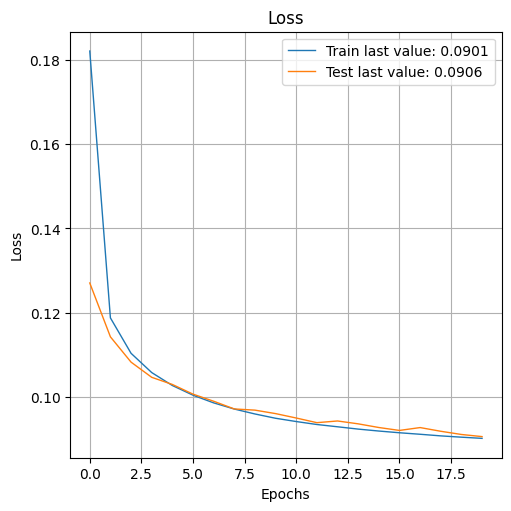

In [ ]:
plot_history(history2)

### Mean absolute errors (MAEs) in test data

In [ ]:
# Get 10 sample test images and their labels
test_samid = np.random.randint(0, len(x_test), size=10)
print(test_samid)
print(y_test[test_samid])

[9707 9018 7304 9904 2651 6795  383 2072 1094 7421]
[3 2 5 2 6 0 7 3 0 4]


1/1 [==============================] - 0s 29ms/step


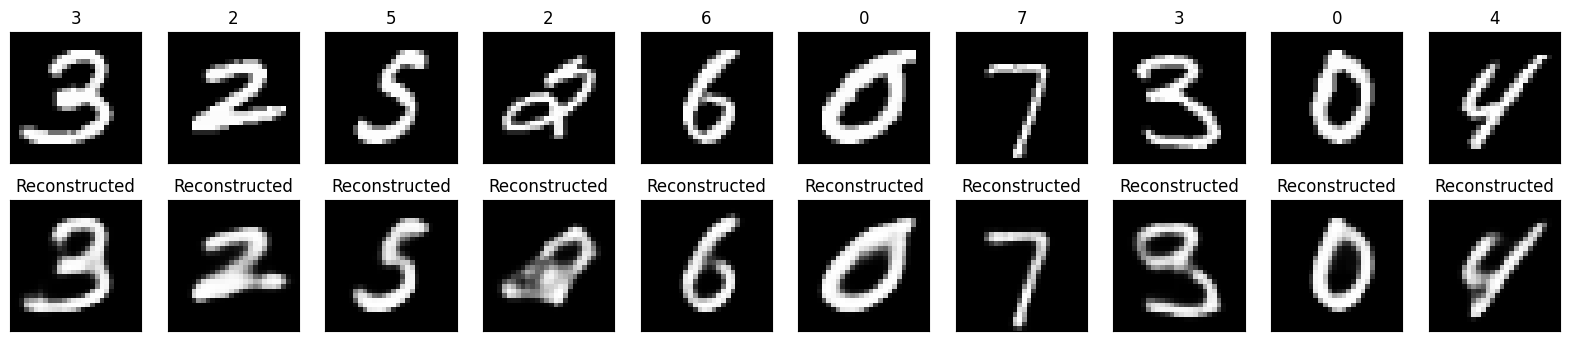

In [ ]:
# Plot reconstructed sample test images
test_sample = x_test[test_samid]
recon_test_sample = convAutoencoder2.predict(test_sample)

img_shape = (28,28)

plt.figure(figsize=(20, 4))
for i in range(10):
    # Display original
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(test_sample[i].reshape(img_shape))
    plt.gray()
    plt.title(y_test[test_samid[i]])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, 10, i + 1 + 10)
    plt.imshow(recon_test_sample[i].reshape(img_shape))
    plt.gray()
    plt.title('Reconstructed')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# MAEs in test data
recon_x_test = convAutoencoder2.predict(x_test)
x_test2 = x_test.reshape(len(x_test), 28*28)
recon_x_test2 = recon_x_test.reshape(len(recon_x_test), 28*28)

losses = tf.keras.losses.mae(x_test2, recon_x_test2)
losses2 = losses.numpy()
print(losses2.shape)
pd.DataFrame(losses2).describe().transpose()

313/313 [==============================] - 1s 3ms/step
(10000,)


count      mean       std       min       25%       50%       75%  \
0  10000.0  0.031616  0.011805  0.005707  0.024553  0.031742  0.038908   

        max  
0  0.085524

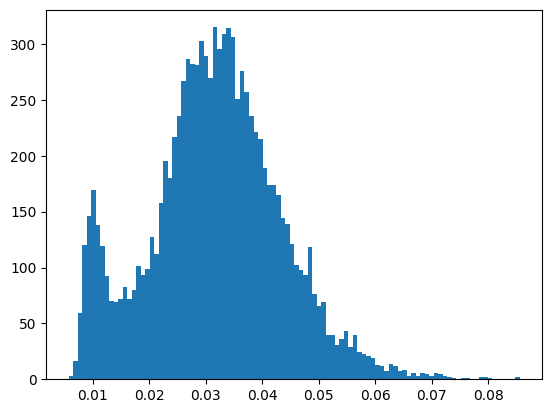

In [ ]:
plt.hist(losses2, bins=100)
plt.show()

### Anomaly detection in test data

In [ ]:
# 20 smallest/largest errors
ord = np.argsort(losses2)
smallestLosses = losses2[ord[:20]]
largestLosses = losses2[ord[-20:]]
smallestLosses_label = y_test[ord[:20]]
largestLosses_label = y_test[ord[-20:]]

print(smallestLosses)
print(largestLosses)
print(smallestLosses_label)
print(largestLosses_label)

[0.00570722 0.00633874 0.00644125 0.00661593 0.00674249 0.00681098
 0.00687827 0.00694627 0.00695482 0.00696784 0.0070218  0.00703861
 0.00704239 0.00704838 0.00705569 0.00707137 0.00709263 0.00720258
 0.00725632 0.00732371]
[0.07126496 0.07131626 0.07136101 0.07141767 0.07173045 0.07213249
 0.07254251 0.07273131 0.07286402 0.07291467 0.07378386 0.07521748
 0.07619009 0.07836422 0.07837117 0.07937279 0.0795443  0.08040671
 0.08488605 0.08552388]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[3 8 2 2 2 8 8 6 2 2 2 2 8 6 2 8 2 3 2 0]


In [ ]:
# Cases with the largest reconst errors
ids_largestError = ord[-20:]
img_sample_errLarge = x_test[ids_largestError].reshape(20, 28, 28)
print(img_sample_errLarge.shape)

(20, 28, 28)


(20, 28, 28, 1)
1/1 [==============================] - 0s 36ms/step


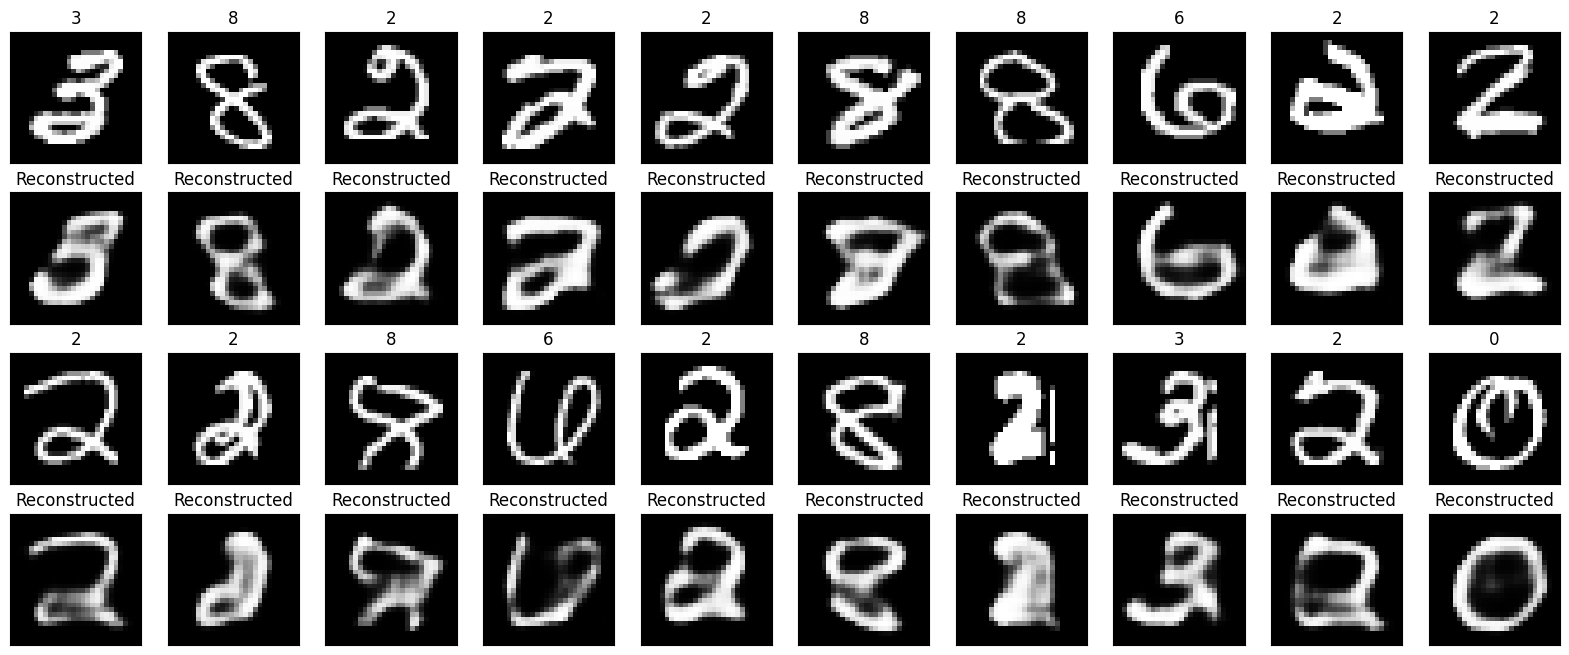

In [ ]:
# Visualize images with the largest reconstruction errors
ids_largestError = ord[-20:]
img_sample_errLarge = x_test[ids_largestError]
print(img_sample_errLarge.shape)

recon_sample_errLarge = convAutoencoder2.predict(img_sample_errLarge)

img_shape = (28,28)

plt.figure(figsize=(20, 8))

for i in range(10):
    # Display original
    ax = plt.subplot(4, 10, i + 1)
    plt.imshow(img_sample_errLarge[i].reshape(img_shape))
    plt.gray()
    plt.title(largestLosses_label[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display reconstruction
    ax = plt.subplot(4, 10, i + 1 + 10)
    plt.imshow(recon_sample_errLarge[i].reshape(img_shape))
    plt.gray()
    plt.title('Reconstructed')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

for i in range(10, 20):
    # Display original
    ax = plt.subplot(4, 10, i + 1 + 10)
    plt.imshow(img_sample_errLarge[i].reshape(img_shape))
    plt.gray()
    plt.title(largestLosses_label[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display reconstruction
    ax = plt.subplot(4, 10, i + 1 + 20)
    plt.imshow(recon_sample_errLarge[i].reshape(img_shape))
    plt.gray()
    plt.title('Reconstructed')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

- Using the autoencoder and its reconstruction errors, we identified some digits that were very poorly written and hard to read.

In [ ]:
# Cases with the smallest reconst errors
ids_smallestError = ord[:20]
img_sample_errSmall = x_test[ids_smallestError].reshape(20, 28, 28)
print(img_sample_errSmall.shape)
smallestLosses_label

(20, 28, 28)


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=uint8)

(20, 28, 28, 1)
1/1 [==============================] - 0s 19ms/step


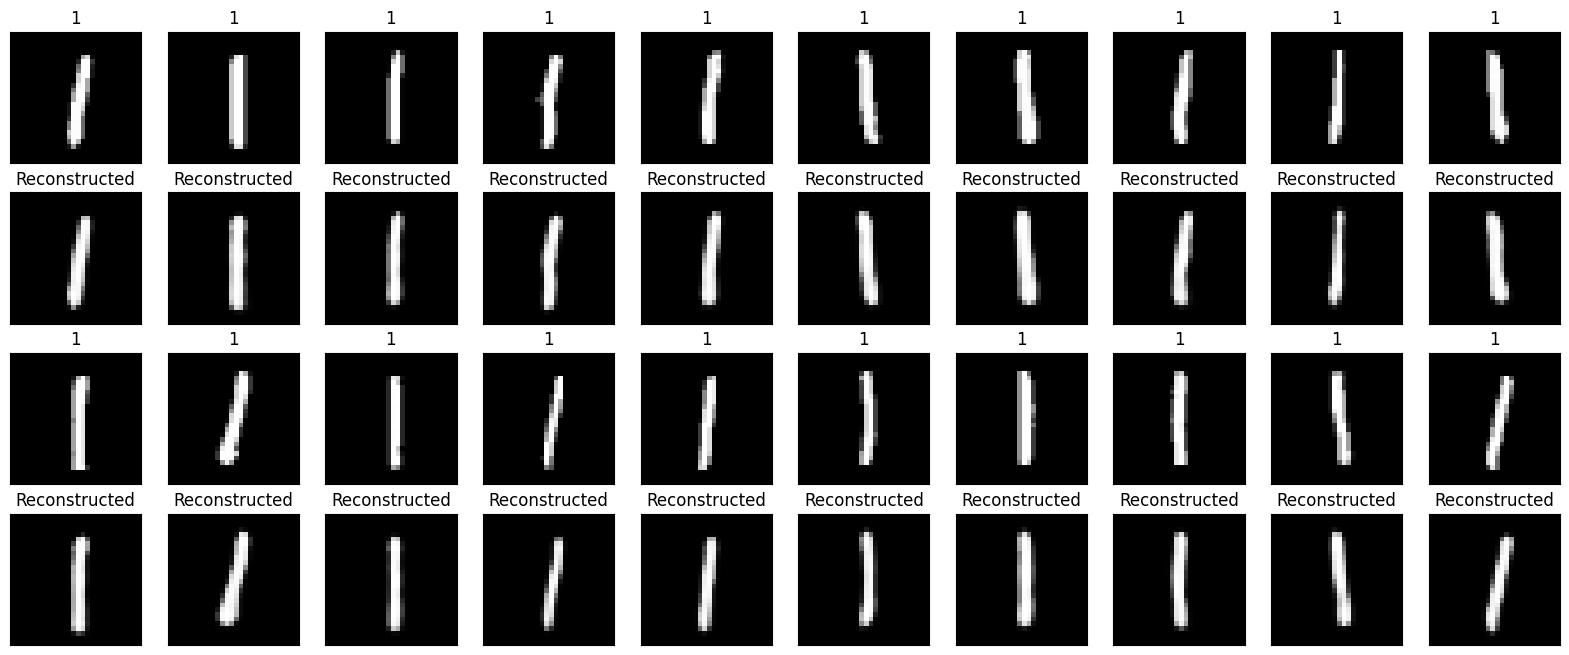

In [ ]:
# Visualize images with the smallest reconstruction errors
ids_smallestError = ord[:20]
img_sample_errSmall = x_test[ids_smallestError]
print(img_sample_errSmall.shape)

recon_sample_errSmall = convAutoencoder2.predict(img_sample_errSmall)

img_shape = (28,28)

plt.figure(figsize=(20, 8))

for i in range(10):
    # Display original
    ax = plt.subplot(4, 10, i + 1)
    plt.imshow(img_sample_errSmall[i].reshape(img_shape))
    plt.gray()
    plt.title(smallestLosses_label[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display reconstruction
    ax = plt.subplot(4, 10, i + 1 + 10)
    plt.imshow(recon_sample_errSmall[i].reshape(img_shape))
    plt.gray()
    plt.title('Reconstructed')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

for i in range(10, 20):
    # Display original
    ax = plt.subplot(4, 10, i + 1 + 10)
    plt.imshow(img_sample_errSmall[i].reshape(img_shape))
    plt.gray()
    plt.title(smallestLosses_label[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display reconstruction
    ax = plt.subplot(4, 10, i + 1 + 20)
    plt.imshow(recon_sample_errSmall[i].reshape(img_shape))
    plt.gray()
    plt.title('Reconstructed')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

- The hand-written digit that is the easiest to reconstruct is "1", the simplest character.

## Summary

1. Autoencoders with 13 layers were applied to satellite images of hurricane damge and MNIST hand-written digits datasets.
2. Abnormal data points were identified using reconstruction errors of the autoencoder modeling.
3. In the images of hurricane damage, images showing severely damaged scenes with lots of debris were identified to have large reconstruction errors.
4. In the images of MNIST digits, very poorly written digits were identified by largest reconstruction errors.